In [1]:
import os
import pandas as pd

In [2]:
path2data = '/content/drive/MyDrive/cv with pytorch/chapter4/data'
path2labels = os.path.join(path2data,"Training400","Fovea_location.xlsx")
labels_df = pd.read_excel(path2labels,index_col="ID")
labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [3]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


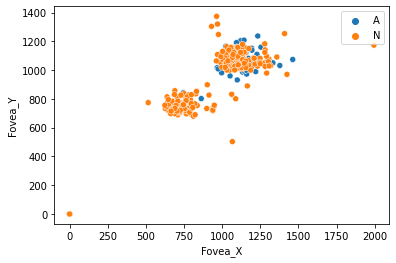

In [4]:
import seaborn as sns
%matplotlib inline
AorN=[imn[0] for imn in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'],
y=labels_df['Fovea_Y'],hue=AorN)

In [5]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt
# fix random seed
np.random.seed(2019)
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows,ncols=2,3
imgName=labels_df["imgName"]
ids=labels_df.index
rndIds=np.random.choice(ids,nrows*ncols)
print(rndIds)

[ 73 371 160 294 217 191]


<Figure size 1080x648 with 0 Axes>

In [6]:
def load_img_label(labels_df,id_):    
    imgName=labels_df["imgName"]    
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
            
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
    img = Image.open(fullPath2img)
    
    # centroid
    x=labels_df["Fovea_X"][id_]
    y=labels_df["Fovea_Y"][id_]
    
    label=(x,y)
    return img,label

In [7]:
def show_img_label(img,label,w_h=(50,50),thickness=2):   
    w,h=w_h                   
    cx,cy=label
    
    # draw a rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="green",width=thickness)

    plt.imshow(np.asarray(img))

(2124, 2056) (1037.89889229694, 1115.71768088143)
(1444, 1444) (635.148992978281, 744.648850248249)
(1444, 1444) (639.360312038611, 814.762764100936)
(2124, 2056) (1122.08407442503, 1067.58829793991)
(2124, 2056) (1092.93333646222, 1055.15333296773)
(2124, 2056) (1112.50135915347, 1070.7251775623)


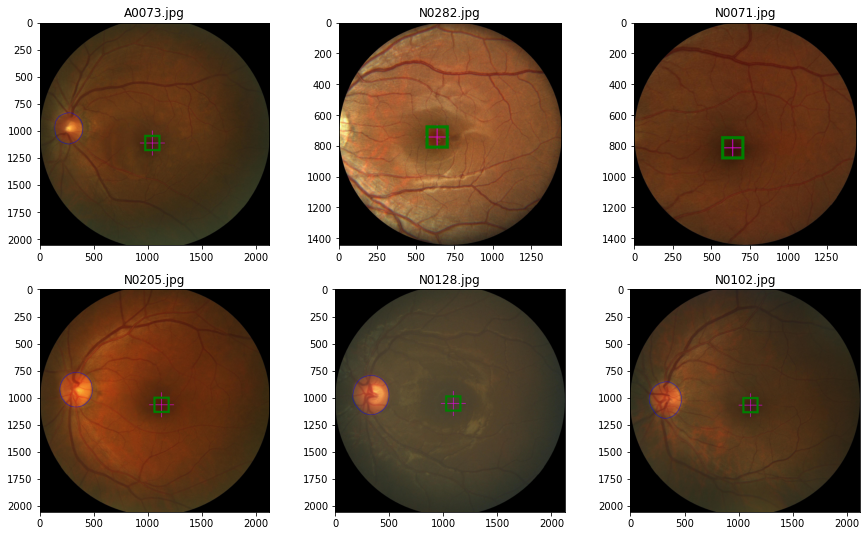

In [8]:
for i,id_ in enumerate(rndIds):
    
    img,label=load_img_label(labels_df,id_)   
    print(img.size,label)
    
    plt.subplot(nrows, ncols, i+1) 
    show_img_label(img,label,w_h=(150,150),thickness=20)
    plt.title(imgName[id_])

In [9]:
h_list,w_list=[],[]
for id_ in ids:
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
        
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
        
    # load image
    img = Image.open(fullPath2img)
    h,w=img.size
    h_list.append(h)
    w_list.append(w)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


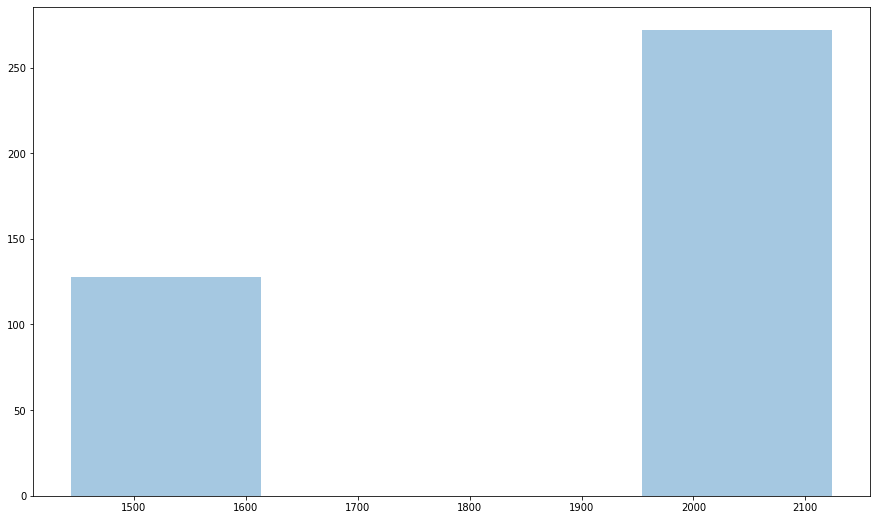

In [10]:
sns.distplot(a=h_list, kde=False)

# **Data Transformation for Object Detection**

In [11]:
import torchvision.transforms.functional as TF

def resize_img_label(image,label=(0.,0.),target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    cx, cy= label
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    label_new= cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new,label_new

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


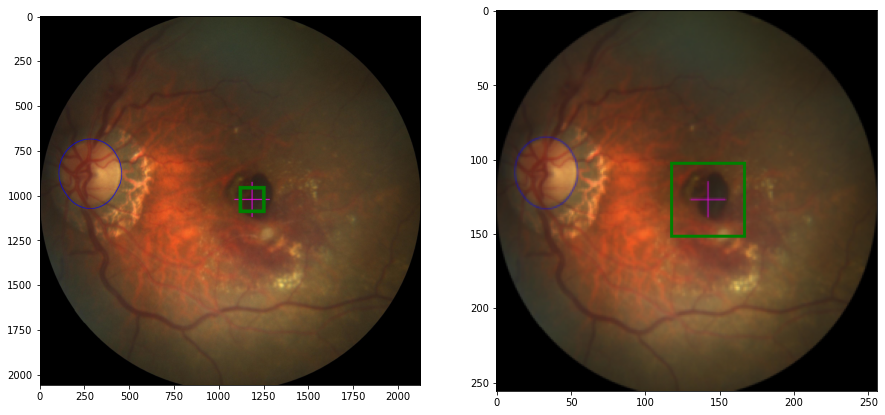

In [12]:
img, label=load_img_label(labels_df,1)   
print(img.size,label)

img_r,label_r=resize_img_label(img,label)
print(img_r.size,label_r)

plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(img_r,label_r)

In [13]:
def random_hflip(image,label):
    w,h=image.size
    x,y=label        

    image = TF.hflip(image)
    label = w-x, y
    return image,label

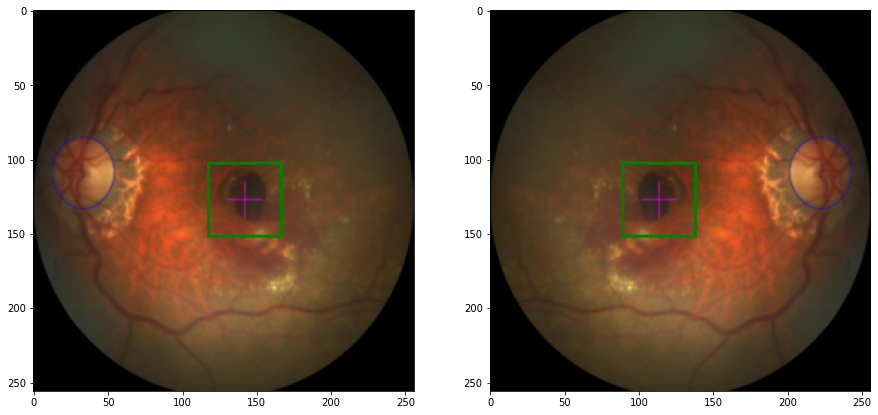

In [14]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# horizantal flip
img_fh,label_fh=random_hflip(img_r,label_r)

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_fh,label_fh)

In [15]:
def random_vflip(image,label):
    w,h=image.size
    x,y=label

    image = TF.vflip(image)
    label = x, h-y
    return image, label


In [16]:
import numpy as np
np.random.seed(1)

def random_shift(image,label,max_translate=(0.2,0.2)):
    w,h=image.size
    max_t_w, max_t_h=max_translate
    cx, cy=label

    # translate coeficinet, random [-1,1]
    trans_coef=np.random.rand()*2-1
    w_t = int(trans_coef*max_t_w*w)
    h_t = int(trans_coef*max_t_h*h)

    image=TF.affine(image,translate=(w_t, h_t),shear=0,angle=0,scale=1)
    label = cx+w_t, cy+h_t
        
    return image,label


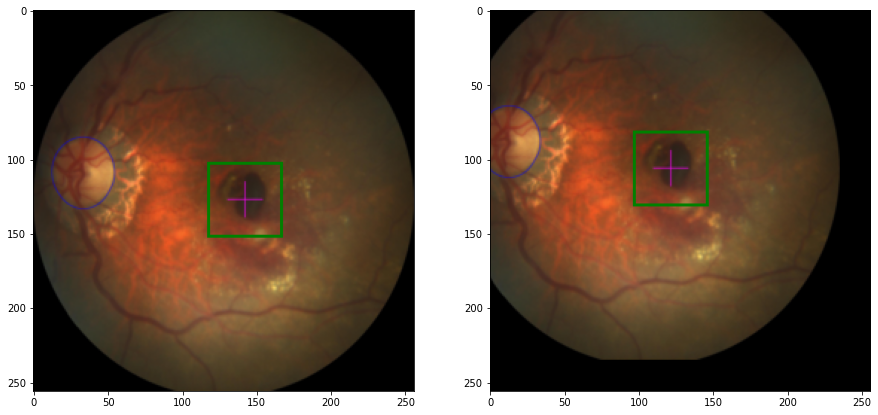

In [17]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# horizantal flip
img_t,label_t=random_shift(img_r,label_r,max_translate=(.5,.5))

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_t,label_t)



In [18]:
def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

In [19]:
import random

def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image=TF.adjust_brightness(image,brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)

    if params["scale_label"]:
        label=scale_label(label,params["target_size"])
        
    image=TF.to_tensor(image)
    return image, label

In [20]:
np.random.seed(0)
random.seed(0)

# load image and label
img, label=load_img_label(labels_df,1)

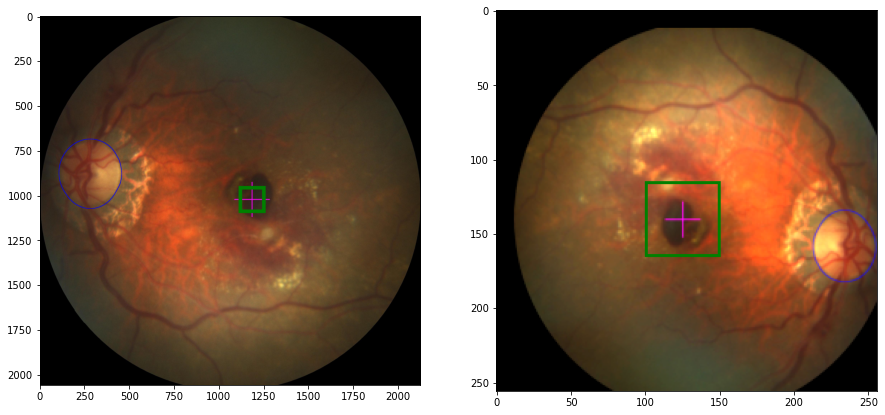

In [21]:


params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}
img_t,label_t=transformer(img,label,params)

plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t),label_t)

In [22]:
from torch.utils.data import Dataset
from PIL import Image
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):      
        pass    
      
    def __len__(self):
        # return size of dataset
        return len(self.labels)
      
    def __getitem__(self, idx):
        pass

In [23]:
def __init__(self, path2data, transform, trans_params):      

    # full path of the labels file
    path2labels=os.path.join(path2data,"Training400","Fovea_location.xlsx")

    # read and extract labels
    labels_df=pd.read_excel(path2labels,index_col="ID")
    self.labels = labels_df[["Fovea_X","Fovea_Y"]].values

    # extract ID and imgName columns
    self.imgName=labels_df["imgName"]
    self.ids=labels_df.index

    self.fullPath2img=[0]*len(self.ids)
    for id_ in self.ids:
        if self.imgName[id_][0]=="A":
            prefix="AMD"
        else:
            prefix="Non-AMD"
        self.fullPath2img[id_-1]=os.path.join(path2data,"Training400",prefix,self.imgName[id_])

    self.transform = transform
    self.trans_params=trans_params


In [24]:
def __getitem__(self, idx):
    # load PIL image
    image = Image.open(self.fullPath2img[idx])  
    label= self.labels[idx]

    # transform to tensor
    image,label = self.transform(image,label,self.trans_params)

    return image, label

In [25]:
AMD_dataset.__init__=__init__
AMD_dataset.__getitem__=__getitem__

In [26]:
trans_params_train={
    "target_size" : (256, 256),
    "p_hflip" : 0.5,
    "p_vflip" : 0.5,
    "p_shift" : 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True,    
}

In [27]:
trans_params_val={
    "target_size" : (256, 256),
    "p_hflip" : 0.0,
    "p_vflip" : 0.0,
    "p_shift" : 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True,    
}

In [28]:
amd_ds1=AMD_dataset(path2data,transformer,trans_params_train)
amd_ds2=AMD_dataset(path2data,transformer,trans_params_val)

In [29]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

320
----------
80


In [30]:
from torch.utils.data import Subset

train_ds=Subset(amd_ds1,train_index)
print(len(train_ds))

val_ds=Subset(amd_ds2,val_index)
print(len(val_ds))

320
80


In [31]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [32]:
import torch

# extract a batch from trainin data
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)

    # convert list to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([8, 3, 256, 256]) torch.float32
tensor([[0.4611, 0.4626],
        [0.5095, 0.4773],
        [0.4827, 0.5057],
        [0.6425, 0.6112],
        [0.7117, 0.7240],
        [0.4832, 0.4769],
        [0.5998, 0.4327],
        [0.4478, 0.4818]])
torch.Size([8, 2]) torch.float32


## **model**

In [33]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [34]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=2,padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3,stride=1,padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3,padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

In [35]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1) # dim is one to add to the channel B*C*H*W

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x

In [36]:
Net.__init__=__init__
Net.forward=forward

In [37]:
params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 2,
            }

model = Net(params_model)

In [38]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
  device = torch.device("cpu")
model=model.to(device)

In [39]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


In [40]:
####################example###############################
m = nn.AdaptiveAvgPool2d((1))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)

torch.Size([1, 64, 1, 1])


In [41]:
loss_func = nn.SmoothL1Loss(reduction="sum")

In [42]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
opt = optim.Adam(model.parameters(), lr=3e-4)
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [43]:
def cxcy2bbox(cxcy,w=50./256,h=50./256):
    # define two new tensors for w and h
    w_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*w
    h_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*h

    # extract cx and cy
    cx=cxcy[:,0].unsqueeze(1)
    cy=cxcy[:,1].unsqueeze(1)
    
    # concat cx,cy,w and h
    boxes=torch.cat((cx,cy, w_tensor, h_tensor), -1) # cx,cy,w,h
    
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2, # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1) # xmax, ymax

In [44]:
import torchvision
def metrics_batch(output, target):
    output=cxcy2bbox(output)
    target=cxcy2bbox(target)
    
    iou=torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()
  
def loss_batch(loss_func, output, target, opt=None):   
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [45]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # convert to tensor
        yb=torch.stack(yb,1)
        yb=yb.type(torch.float32).to(device)
        
        # get model output
        output=model(xb.to(device))
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [46]:
import copy
def train_val(model, params):
    # extract parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }    
    
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        # train the model
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            

        print("train loss: %.6f, accuracy: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, accuracy: %.2f" %(val_loss,100*val_metric))
        print("-"*10) 
        

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [47]:
loss_func=nn.SmoothL1Loss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "/content/drive/MyDrive/cv with pytorch/chapter4"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 60,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights_smoothl1.pt",
}

# train and validate the model
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/59, current lr=0.0001
Copied best model weights!
train loss: 0.057211, accuracy: 12.64
val loss: 0.025629, accuracy: 14.02
----------
Epoch 1/59, current lr=0.0001
Copied best model weights!
train loss: 0.018401, accuracy: 26.70
val loss: 0.012931, accuracy: 39.28
----------
Epoch 2/59, current lr=0.0001
Copied best model weights!
train loss: 0.011320, accuracy: 36.15
val loss: 0.010465, accuracy: 57.42
----------
Epoch 3/59, current lr=0.0001
train loss: 0.010502, accuracy: 33.94
val loss: 0.010607, accuracy: 55.14
----------
Epoch 4/59, current lr=0.0001
Copied best model weights!
train loss: 0.008266, accuracy: 38.81
val loss: 0.010254, accuracy: 42.41
----------
Epoch 5/59, current lr=0.0001
Copied best model weights!
train loss: 0.008489, accuracy: 38.48
val loss: 0.009998, accuracy: 45.59
----------
Epoch 6/59, current lr=0.0001
train loss: 0.007232, accuracy: 42.43
val loss: 0.011752, accuracy: 28.75
----------
Epoch 7/59, current lr=0.0001
Copied best model weights!
tra